In [79]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.optimizers import adam
# baseline cnn model
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.optimizers import SGD
from os import listdir
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import preprocess_input

In [7]:
def load_dataset_plusplus(trainPath, testPath):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1/255)
    validation_datagen = ImageDataGenerator(rescale=1/255)

    # Flow training images in batches of 120 using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
            trainPath,  # This is the source directory for training images
#             classes = ['correct', 'incorrect'],
            target_size=(200, 250),  # All images will be resized to 200x200
            batch_size=120,
            # Use binary labels
            class_mode='binary')

    # Flow validation images in batches of 19 using valid_datagen generator
    validation_generator = validation_datagen.flow_from_directory(
            testPath,  # This is the source directory for training images
#             classes = ['correct', 'incorrect'],
            target_size=(200, 250),  # All images will be resized to 200x200
            batch_size=19,
            # Use binary labels
            class_mode='binary',
            shuffle=False)
    return train_generator, validation_generator

In [12]:
train_generator, validation_generator = load_dataset_plusplus(r'C:\ejemplo_nuevo\train', r'C:\ejemplo_nuevo\validation')

Found 600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [43]:
# define cnn model
def define_model_mierder():
    
    model = Sequential()

    # This is the first
    model.add(Flatten(input_shape = (200,250,3)))
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dense(1, activation=tf.nn.sigmoid))
    model.summary()
    model.compile(optimizer = adam(lr=0.001, decay=1e-6), loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [81]:
# define cnn model
def define_model():
    model = Sequential()

    # This is the first
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(200, 250, 3)))
    model.add(MaxPooling2D(2,2))
    # The second 
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The third
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fourth 
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # The fifth
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    # Flatten the results to feed into a DNN
    model.add(Flatten())
    # 512 neuron hidden 
    model.add(Dense(512, activation='relu'))
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(optimizer = adam(lr=0.001, decay=1e-6), loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
def train_model(model, train_generator, validation_generator):
    history = model.fit(train_generator,steps_per_epoch=8,epochs=15,verbose=1,validation_data = validation_generator,validation_steps=8)
    return history

In [25]:
def evaluate_model(model, validation_generator, history):
    # evaluate a model using k-fold cross-validation
    scores, histories = list(), list()
    _, acc = model.evaluate(validation_generator)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    histories.append(history)
    return scores, histories

In [46]:
def metrics(model, validation_generator):
    STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
    validation_generator.reset()
    preds = model.predict(validation_generator,
                      verbose=1)
    fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [57]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    # plot loss
    print(histories[0].history['loss'])
    print(histories[0].history)
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[0].history['loss'], color='blue', label='train')
    plt.plot(histories[0].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[0].history['accuracy'], color='blue', label='train')
    plt.plot(histories[0].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [58]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [75]:
def se_prendio_la_wea():
    print('iniciating definition of the model')
    #definicion mierder del modelo
#     model = define_model_mierder()
    #definicion buena del modelo
    model = define_model()

    print('entrenamiento del modelo')
    history = train_model(model, train_generator, validation_generator)

    print('iniciating the evaluation of the model')
    scores, histories = evaluate_model(model, validation_generator, history)
    metrics(model, validation_generator)
    
    print('iniciating the diagnostics')
    summarize_diagnostics(histories)
    
    # summarize estimated performance
    print('iniciating the diagnostic of performance')
    summarize_performance(scores)
    
    model.summary()
    # save model
    print('saving the model')
    model.save('final_model.h5')

iniciating definition of the model
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 198, 248, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 99, 124, 16)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 97, 122, 32)       4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 48, 61, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 29, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)

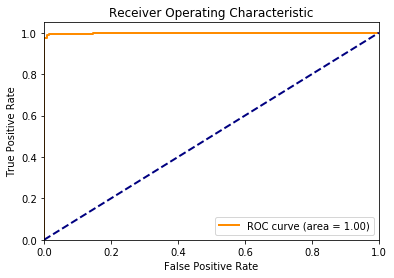

iniciating the diagnostics
[0.7253847569227219, 0.6899993568658829, 0.675057590007782, 0.613733284175396, 0.47297903150320053, 0.28791054897010326, 0.15010932181030512, 0.08189130015671253, 0.17658318346366286, 0.057840427150949836, 0.03721656231209636, 0.026168281445279717, 0.014221213990822434, 0.006553234677994624, 0.003455467289313674]
{'val_loss': [0.6719129085540771, 0.6725320816040039, 0.7470039129257202, 0.5819737911224365, 0.5392137765884399, 0.6283907890319824, 0.02733897790312767, 0.049976836889982224, 0.011187819764018059, 0.10124829411506653, 0.006318176630884409, 0.0015023580053821206, 0.03443808853626251, 0.020471390336751938, 0.00012078662257408723], 'val_accuracy': [1.0, 0.8092105388641357, 0.8059701323509216, 0.6184210777282715, 0.7631579041481018, 0.8208954930305481, 0.9802631735801697, 0.9868420958518982, 0.9552238583564758, 0.9868420958518982, 0.9850746393203735, 0.9736841917037964, 0.9934210777282715, 0.9701492786407471, 0.9934210777282715], 'loss': [0.72538475692

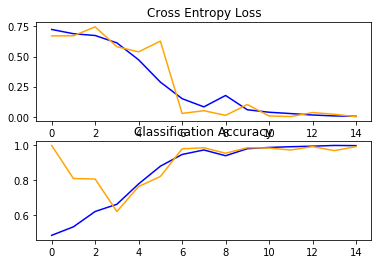

iniciating the diagnostic of performance
Accuracy: mean=99.000 std=0.000, n=1


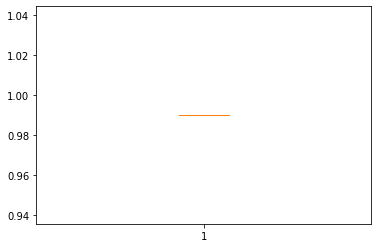

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 198, 248, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 99, 124, 16)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 97, 122, 32)       4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 48, 61, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 46, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 29, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 27, 64)      

In [82]:
se_prendio_la_wea()

In [64]:
def load_image(filename):
# load the image
    img = load_img(filename, grayscale=False, target_size=(800, 1000))
# convert to array
    img = img_to_array(img)
# reshape into a single sample with 1 channel
    img = img.reshape(3,400,500)
# prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [90]:
def run_example1():
    # load model
    model = load_model('final_model.h5')
# load the images
    #img = np.ndarray(shape=(1, 3, 400, 500),
    #                    dtype=np.float32)
    
    image = load_img('incorrecto.png')
    input_arr = img_to_array(image, "channels_last")
    input_arr = np.array([input_arr])  # Convert single image to a batch.

    #img[0] = extract_features('blanco.png')
    #print (img.shape)
    
    # predict the class
    digit = model.predict(input_arr)
    if(digit[0][0] == 1):
        print("incorrecto")
    else: 
        print("correcto")

In [91]:
run_example1()

incorrecto
